# Cancer Metastasis Networks


By: 
<br>
Bryan Trac - 21704976 
<br>
Terence Leong - 21707741
<br>
Vlad Matveev - 21965049
<br>
Dickson Hee - 21900505

## 1. Introduction

Cancer is one of the most well known and deadly diseases in our modern age with an estimated 50,000 Australians dying as a result of cancer in 2019 (Australian Institute of Health and Welfare, 2019). As a result, more and more funding is being put into cancer reasearch to find a cure.

Various approaches have been taken to further our knowledge regarding cancer. One of which is the modelling of cancer metastasis networks. According to all cases thus far, early detection and treatment of cancer is the most impactful way to reduce mortality rates. Hence, being able to predict the behaviour of cancer cells and the way they spread in the early stages is vital to the treatment process.

### 1.1 Background Information

Cancer refers to the abnormal growth of cells whose genetic structure has been damaged. These cells can grow uncontrollably and even spread to other parts of the body, causing further damage. This spreading of cancer cells through the blood stream to other parts of the body is known as cancer metastasis and is one of the major causes of cancer-related deaths.

Due to the fact that the cancerous cells travel through the bloodstream, there are only a set amount of pathways for these cells to travel. Conventional wisdom would also suggest that they would most likely travel to nearby organs and tissues. So it should be possible to predict the locations of metastasis sites if the location of the primary tumour is known. Knowing the most likely locations where these metastasis sites could develop will assist medical practitioners in pre-emptively monitoring and treating cancer patients before their conditions get worse and thus potentially save lives.


## 2. Metastasis Networks

The paper Cancer metastasis networks and the prediction of progression patterns uses graph based modelling to deduce the relationships between different tumour types and metastases to create prediction of likely metastasis sites given the location of a primary tumour (Chen, et al., 2009). The paper uses the MedPar dataset which contains over 6 million data entries of hospital visits. A subset of this database is used to calculate the correlation between tumour and metastasis locations.

One separate graph was created for each major tumour type (such as breast, colon and prostate). The graph contained the primary tumour as the central node. Then branching out from it were edges to nodes for each of the possible metastasis sites.

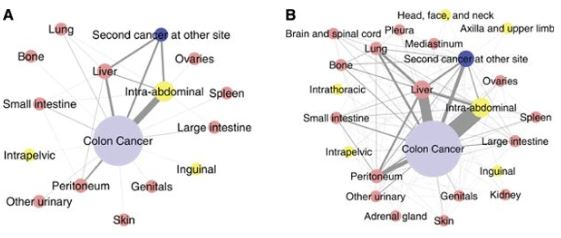

In [3]:
from IPython.display import Image
Image("branchNetwork.JPG")

The weight of each of the edges was based off of the probability that a metastasis site would form at that location. Most of the calculation work is done to generate this probability and they will be explored in the next section.

The paper also explores into using the existing information regarding cancer metastasis networks to predict the likeliness of metastasis occuring in various sites from a given primary site. Due to the size of the project, we will only be focusing on actually graphing the cancer metastasis network and not predicting metastasis itself. However a quick overview of how they went about predicting metastasis for given primary cancer site will still be given.

This is accomplished by incorporating temporal dynamics as well as subtle relational properties onto the network. For each patient, the probability of an accurate prediction given primary cancer type X and metastases is given by an equation that won't be outlined here.

## 2.1 Construction of Cancer Metastasis Networks

Nodes in a cancer metastasis network represent the different sites that metastases arise for a given primary tumour. The size of each node is determined by its conditional incidence or hazard. 

$h_{X,met(t)}=\frac{m_{met(t)}}{N_{X_{t}}}$

$m_{met(t)}$: Number of diagnoses of metastasis at time  *t*

$N_{X(t)}$:  Number of patients with primary tumour *X* at time *t*

To quantify metastasis development, the co-occurrence at every point in time of each incidence of metastasis. The co-occurrence establishes a link between the primary tumours and its metastasis sites. It also allows for linking between metastasis sites. 


## 2.2 Co-occurence Measures

The co-occurrence was measured using two measures, the $\varphi$-correlation and relative risk. Links between sites may be either between a primary site and its metastases sites, or between different metastasis sites. Relative risk is used commonly in medical literature but has certain drawbacks in this context. 

$\sigma_{x,ij}(t)=\frac{N_x(t)C_{ij}(t)-m_i(t)m_j(t)}{\sqrt{m_i(t)m_j(t)[N_x(t)-m_i(t)][N_x(t)-m_j(t)]}}$

Where $C_{ij}(t)$ is the number of co-occurences at time t; whilst $i$ and $j$ represent particular sites of metastasis or the primary tumour itself.

## 2.3 Difference in Implementation

The main difference in our implementation is the dataset used to create our models. The subset used in the paper contains roughly 2 million entries of patients exhibiting cancer metastasis over a period of time. Our dataset has less than 20,000 entries that exhibit metastasis and only at one point in time. The lack of a large dataset results in us having to change our implementation methods to replicate similar results in the paper. 

With the lack of a large dataset in mind, the team has decided to only create a single model representing the metastasis network at a single point in time, with emphasis on the connections between different metastasis sites. 

## 3 Creating the Model

To start off, we will need to load in our dataset. Our dataset was obtained from the Human Cancer Metastasis Database (HCMD) which may not be as detailed as the MedPar database used in the research paper however it should be sufficient in creating the metastasis network. 

Here is the implementation for the creation of our model.


In [4]:
#import all necessary packages
import csv
from collections import Counter
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
import thinkplot
from thinkstats2 import Pmf
from thinkstats2 import Cdf

#intialise variables
filename = 'metastasis.csv'
links =[]
#tumour to metastasis pairs
entry = []
#location of primary tumour
locs = []
#location of metastasis
meta = []

#read in the csv file specified by 'filename'
with open(filename) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    prev_exp = ''
    prec_class = ''
    next(csv_reader)
    for row in csv_reader:
        #don't record samples from the same experiment with the same results
        if row[0] != prev_exp and row[6] != prec_class:
            
            #record the current experiment number
            prev_exp = row[0]
            prec_class = row[6]

            #store data in lists
            for instance in row[12].split(','):
                entry.append(row[11] + ',' + instance)
            locs.append(row[11])
            meta.extend(row[12].split(','))
            links.extend(entry)
            entry =[]

We start off by reading in the file containing all the data from HCMD. This is accomplished by iterating through the entire file and only recording unique experiments with unique results, all other data is disregarded.

In [5]:
#get unique tumour locations and count them
unique_locs, counts_locs = np.unique(locs, return_counts=True)
locs_data = dict(zip(unique_locs, counts_locs))


#get unique metastasis locations and count them
unique_meta, counts_meta = np.unique(meta, return_counts=True)
meta_data = dict(zip(unique_meta, counts_meta))

print(locs_data)
print(meta_data)

{'adrenal gland': 2, 'bladder': 17, 'bone': 2, 'brain': 1, 'breast': 93, 'cervix': 7, 'colorectal': 1, 'colorectum': 74, 'esophagus': 12, 'eye': 3, 'femur': 2, 'hypopharynx': 1, 'kindey': 23, 'larynx': 2, 'liver': 28, 'lung': 4, 'midgut': 4, 'mouth': 1, 'nasopharynx': 2, 'ovary': 1, 'pancreas': 45, 'penis': 3, 'prostate': 49, 'skin': 38, 'small intestine': 11, 'stomach': 3, 'synovium': 1, 'testis': 2, 'thymus': 2, 'thyroid': 15, 'tongue': 2, 'uterus': 4}
{'': 60, 'adrenal gland': 13, 'bone': 41, 'brain': 27, 'breast': 4, 'chest wall': 4, 'fat': 3, 'kindey': 4, 'liver': 107, 'lung': 52, 'lymph node': 91, 'muscle': 3, 'omentum': 1, 'other': 4, 'ovary': 1, 'pancreas': 2, 'peritoneal surfaces': 2, 'peritoneum': 8, 'pleura/pleural effusion': 1, 'posterior peritoneum': 5, 'skin': 6, 'small intestine': 3, 'soft tissue': 3, 'spleen': 3, 'unknown': 27, 'viscera': 2}


The entries in this database contain quite a number of fields that we don't need so they were pruned off. At this point we have **locs_data** which is a dictionary of unique primary tumours and the number of times they have been encountered; **meta_data** which is a dictionary of unique metastasis sites and the number of times they have been encountered.

In [9]:
unique_links, counts_links = np.unique(links, return_counts=True)
links_data = dict(zip(unique_links, counts_links))

print('Number of unique links: ' + str(len(unique_links)))

Number of unique links: 113


Next we create another dictionary, **links_data**, which contains every unique tumour to metastasis pair and the frequency that they occurred in.

Lastly we will need a way to measure the correlation between the tumours and metastases. In the paper a correlation coefficient is used. It is explained vaguely and its implementation is very computationally large due to the number of sums needed for each unique tumour metastasis pair. The paper mentions another method, fractional probability, which is equally effective for measuring the correlation for data with no timestamps. As our dataset has no timestamps, this method will be the one which we implement.

The fractional method simply looks at historical data. To use an example, if there were 10 instances of lung cancer in the dataset and 3 of the patients developed metastasis sites in their liver, the probability or correlation from lung to liver would be $\frac{3}{10}$ or 0.3.

In [10]:
#create a probability dictionary where each key is a link and the data is the fractional probability of that tumour generating that metastasis
probs = {}
for link in unique_links:
    freq = links_data.get(link)
    tumour = link.split(',')[0]
    #prob = frequency of that tumour to metastasis pair over the frequency of that tumour
    probs[link]=freq/locs_data.get(tumour)

Once these dictionaries are created, we will be able to start analysing the data and create some models.

## 4. Plotting Clustergram

The paper uses various techniques to model their dataset. One way to show the relationship between tumours and metastasis sites was to use what they refer to as a clustergram. So here we will create one using our data to compare the two different datasets and get some insights into the data that we have.

In [11]:
#intialse the clustergram and fill all entries with 0
heat = [[0 for temp in unique_locs] for temp2 in unique_meta]

loc_cnt =0
meta_cnt =0

#fill the clustergram with the information from the probility dictionary
for loc in unique_locs:
    for meta in unique_meta:
        w = probs.get(loc+','+meta)
        if w is not None:
            heat[meta_cnt][loc_cnt]=w
        meta_cnt=meta_cnt +1
    loc_cnt = loc_cnt + 1
    meta_cnt = 0

Once the 2D matrix has been created, and filled in we can now display it.

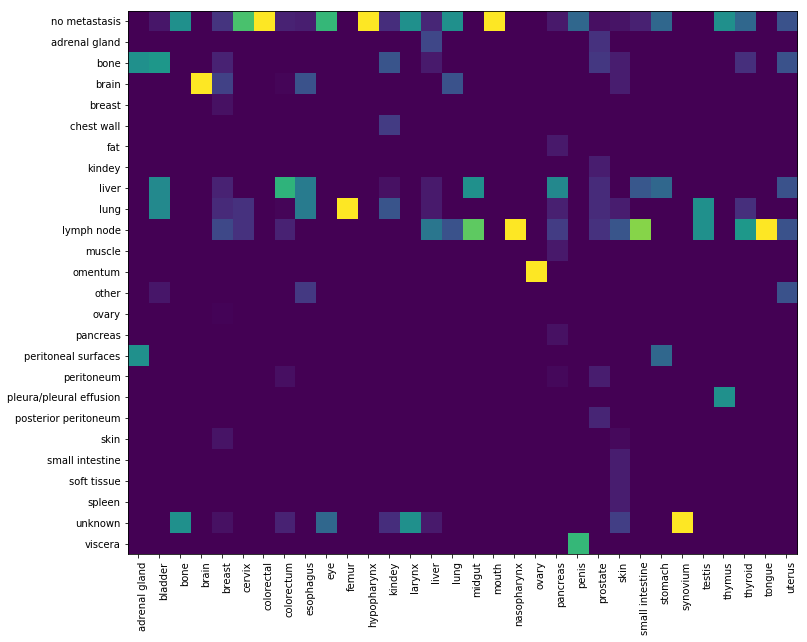

In [12]:
#plot the data structure using the mathplotlib package
clustergram = np.array(heat)
fig, ax = plt.subplots(figsize=(15, 10))
im = ax.imshow(clustergram)

#transform axes
ax.set_xticks(np.arange(len(unique_locs)))
ax.set_yticks(np.arange(len(unique_meta)))
ax.set_xticklabels(unique_locs)
#rename blank '' to no metastasis to make it more readable
unique_meta[0] = 'no metastasis'
ax.set_yticklabels(unique_meta)

plt.setp(ax.get_xticklabels(), ha="right", rotation=90, rotation_mode="anchor")
plt.show()

It is difficult to determine the similarities of the figure above to the one in the paper however, the low amount of highly correlated pairs is similar across both figures. The clustergram from the research paper is displayed below.

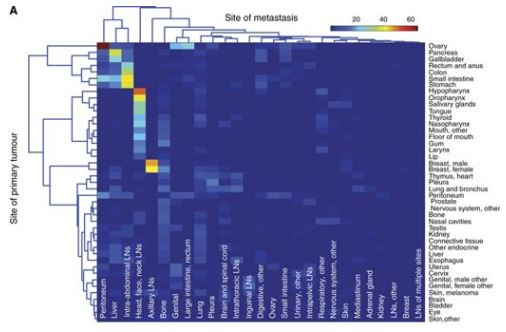

In [13]:
from IPython.display import Image
Image("clustergram.JPG")


To get a more focused look at the dataset we decided to threshold the data to remove tumour types with a low amount of entries in the dataset. Here we set it to 20 and complete the same process as above.

In [14]:
threshold =15

#create a list containing all tumours above the threshold
allowlist = []
for loc in unique_locs:
    if locs_data.get(loc) >threshold:
        allowlist.append(loc)

#now when creating the heatmap, only tumours in the allowlist are added to the datastructure
heat = [[0 for temp in allowlist] for temp2 in unique_meta]
loc_cnt =0
meta_cnt =0
for loc in allowlist:
    for meta in unique_meta:
        w = probs.get(loc+','+meta)
        if w is not None:
            heat[meta_cnt][loc_cnt]=w
        meta_cnt=meta_cnt +1
    loc_cnt = loc_cnt + 1
    meta_cnt = 0

removelist = []
for index,row in enumerate(heat):
    if row == [0 for length in range(len(allowlist))]:
        heat.pop(index)
        removelist.append(index)

unique_m = list(unique_meta)
for item in reversed(removelist):
    unique_m .pop(item)

This left us with 8 remaining primary tumours sites across the entire dataset. This was definitely not ideal, but having outliers within the heatmap would skew the results way more negatively.

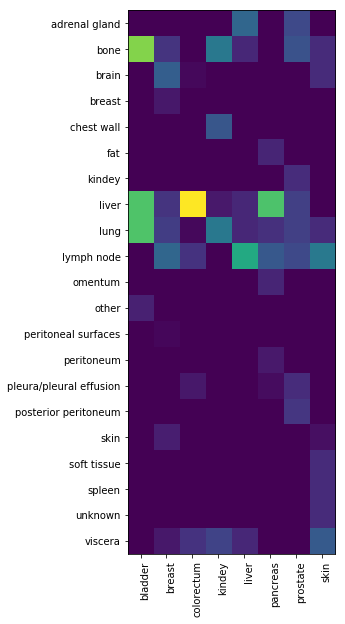

In [16]:
h = np.array(heat)
fig, ax = plt.subplots(figsize=(15, 10))
im = ax.imshow(h)

ax.set_xticks(np.arange(len(allowlist)))
ax.set_yticks(np.arange(len(unique_m )))
ax.set_xticklabels(allowlist)
unique_meta[0] = 'no metastasis'
ax.set_yticklabels(unique_m)

plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
plt.show()

As you can see, even now most of the heatmap is completely dark, which imply that co-occurrence was not seen amongst those cancer sites. This is similar to the heatmap shown in the research paper where most of the combinations were not available. Due to the difference in dataset, we can't compare the results directly. However, we can make an assumption that our mapping is true to how metastasis occurs in real life at least to the extent of our dataset.

## 5. Plotting Graphs

The next step is to create graphs to model the data. We will start with a simple graph showing all the primary tumours.



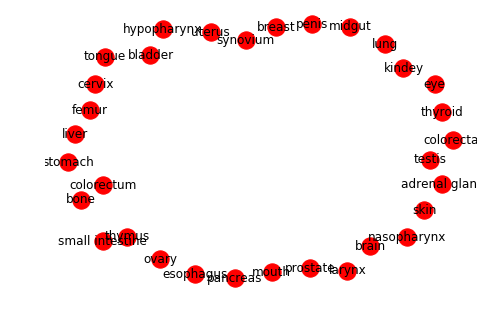

In [17]:
#create a directed multigraph
G=nx.MultiDiGraph()
for loc in unique_locs:
    #uncomment line below to see graph of threshold data 
    #if locs_data.get(loc) >threshold:
    G.add_node(loc)

#show the current nodes
nx.draw(G,with_labels=True)

The above shows the primary tumours which will make up the graph. (Uncomment the if statement above to apply a threshold to the graph).

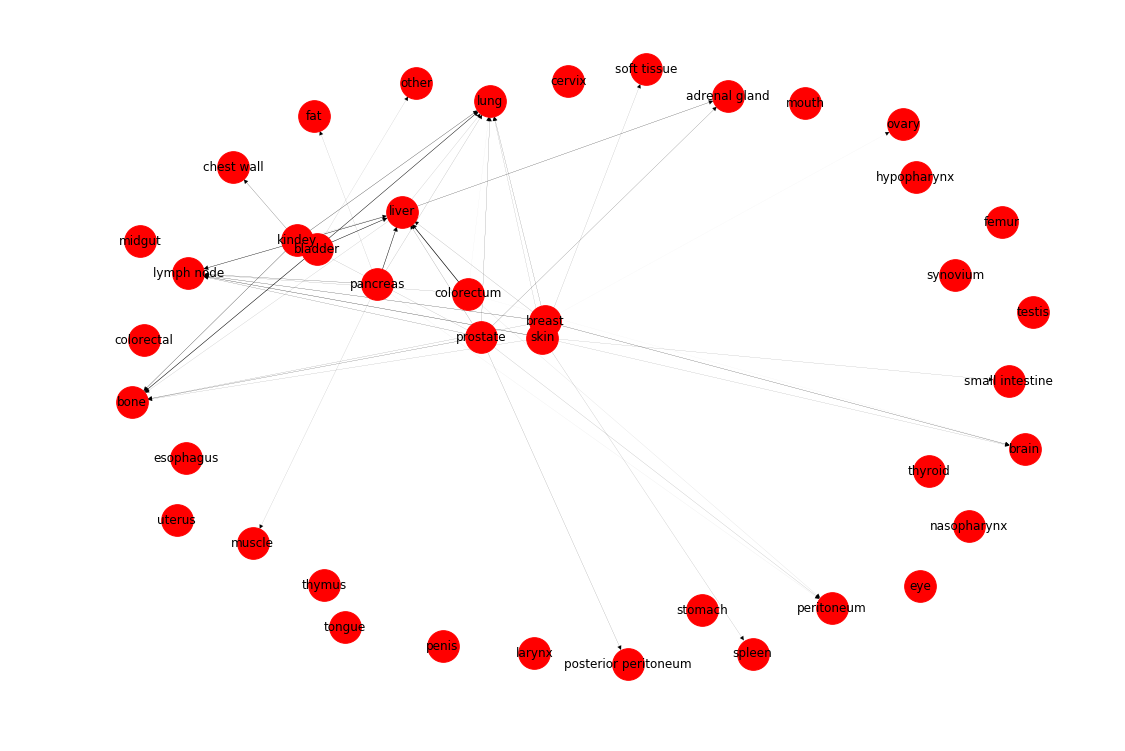

In [18]:
#for each unique link in the data, add an edge to the graph
for ld in links_data:
    if ld.split(',')[1] =='' or ld.split(',')[1] =='unknown':
        continue
    w = probs.get(ld)
    edge = ld.split(',')
    if edge[0] in allowlist:
        G.add_edge(edge[0],edge[1],weight= w)

edges = G.edges()
weight = [G[u][v][0]['weight'] for u,v in edges]

plt.figure(figsize=(15, 10))
nx.draw_spring(G,node_size=1000,with_labels=True,center=allowlist, width = weight,iterations=100)

Next we add edges to the graph as well as the metastasis sites. We did consider making nodes for metastasis sites a different colour however, some metastasis sites share the same location as primary tumours. From our knowledge, having a primary tumour in the lungs or a metastasis site in the lungs does not have many significant differences. Furthermore, as metastasis sites can spread and cause more sites, differentiating between the two does not seem necessary. Therefore the tumours and metastasis sites are set to the same default color in our figure.

For each tumour to metastasis site entry in the dictionary, we add a directed edge from the tumour to the metastasis site. The weight of this edge is simply the corresponding probability entry in the probability dictionary. Then the thickness of the edge is set according to this probability in order to provide a better visual representation of the relationships present.

We also considered altering the size of each node to correspond to the frequency that particular cancer site occur amongst patients. However this idea was sidelined due to the fact that it wouldn't illustrate anything related to cancer spread.

In [19]:
#function to a create a metastasis graph for a single tumour
def tumourGraph(tumour):
    graph =nx.MultiDiGraph()

    for ld in links_data:
        #ignore if blank (no metastasis) or unknown location
        if ld.split(',')[1] =='' or ld.split(',')[1] =='unknown' or ld.split(',')[0] != tumour:
            continue
        w = probs.get(ld)
        edge = ld.split(',')
        if edge[0] in allowlist:
            graph.add_edge(edge[0],edge[1],weight= w*10)

    edges = graph.edges()
    weight = [graph[u][v][0]['weight'] for u,v in edges]

    plt.figure()
    nx.draw_spring(graph,node_size=1000,with_labels=True, width = weight)

We then defined the above function that graphs each individual primary tumour and their cancer metastasis network. Each node corresponds to the anatomical site of metastases, whilst the width of the links represent the strength of metastasis co-occurrence for two sites similar to the previous graph. Now we can have a quick insight into some of the tumours.

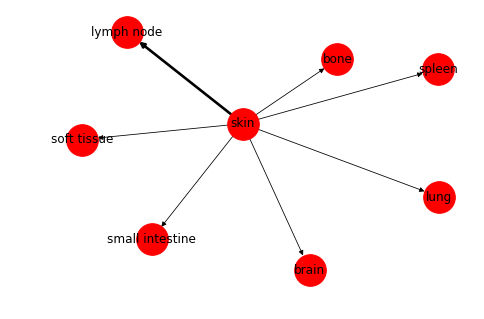

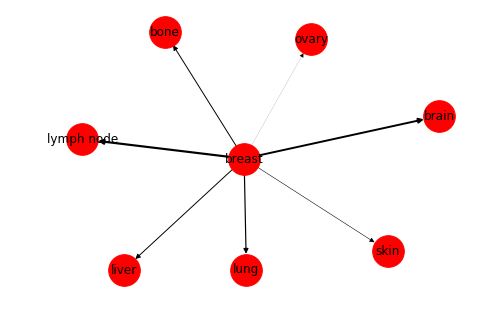

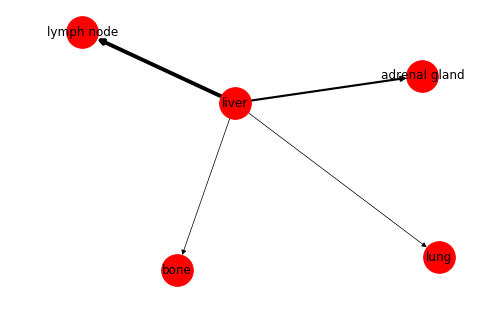

In [26]:
tumourGraph('skin')
tumourGraph('breast')
tumourGraph('liver')

The above are three examples from our dataset that have a reasonably dense network of metastasis sites of varying weight. Getting an exact match with the paper is difficult due to the differing datasets however, the overall shape and distribution of weight is very similar.

## 6. Analysis

### 6.1 Clustering Coefficient

After this quick insight, we will go back to analysing the dataset as a whole. We will first take a look at the clustering coefficient and average path length using functions from chapter 4 of the think complexity textbook.

In [21]:
def avg_clustering(G,trials=1000):
    from networkx.algorithms.approximation import average_clustering
    return average_clustering(G, trials, seed = RANDOM_SEED)

def degrees(G):
    return [G.degree(u) for u in G]

We decided to use undirected graphs for analysis as opposed to directed graphs. This is due to the sheer added complexity a directed graph provides compared to an undirected graph.

In [23]:
#make undirected graph
threshold =1
RANDOM_SEED = 100

G=nx.Graph()
for loc in unique_locs:
    if locs_data.get(loc) >threshold:
        G.add_node(loc)
        
for ld in links_data:
    if ld.split(',')[1] =='' or ld.split(',')[1] =='unknown':
        continue
    w = probs.get(ld)
    edge = ld.split(',')
    if edge[0] in allowlist:
        G.add_edge(edge[0],edge[1],weight= w)


#call clustering coefficient function
coeff = avg_clustering(G)

#print result
coeff

0.136

The clustering coefficient for the metastasis dataset is fairly low which is similar to that of a BA graph. This would imply that cancer metastasis networks are that of a scale free network. However, the average path length could not be calculated due to isolated nodes and subgraphs. For example, eye cancer had no instances of metastasis and no tumours in the dataset had metastasis sites in the eye.

### 6.2 Degree Distribution

It is difficult to discern what type of graph we are working with using these results below so next we will take a look at the degree distributions

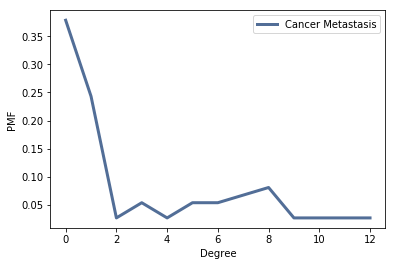

In [27]:
pmf_m = Pmf(degrees(G))
thinkplot.Pdf(pmf_m, label='Cancer Metastasis')
thinkplot.config(xlabel='Degree', ylabel='PMF')

As you can see from the probability mass function above, there seems to be nodes that have zero degree distribution in our data. This is due to the fact that eye cancer was found to be incapable of spreading to other metastasis sites. However, due to our limited database we can't be certain that this is true in all cases of eye cancer, but it is at least applicable to our scenario.

Taking this one step further we decided to threshold the data to remove primary cancer sites such as the eye that have zero degree distribution. The probability mass function after thresholding resembled that of a power law relationship.

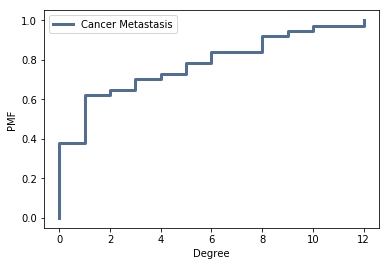

In [28]:
cdf_m = Cdf(degrees(G))
thinkplot.Cdf(cdf_m, label='Cancer Metastasis')
thinkplot.config(xlabel='Degree', ylabel='PMF')#,xscale='log',yscale='log')

The distribution lines in our PMF and CDF graphs were rather erratic and the range was also relatively small, which is once again due to our limited database size.

## 7. Conclusion

Due to the power law-like shape of the distribution the conclusion that we can draw from this dataset is that a few cancer types spread to multiple locations while a vast majority of cancers spread to only a few places. This result makes sense due the structure of the human body. The different parts of the body are more connected than other parts.

Our research shows that the data follows familiar rules within models that we have studied in the unit, thus increasing the likelihood of developing an all-encompassing model relating every cancer type to its subsequent metastasis sites.

### 7.1 Future Work

One of the major restrictions of our research was the availability of the datasets. Due to the lack of funding, the available datasets the project had to work with were very scarce. The chosen dataset had a vast number of records which made it sufficient to work with. However, having a dataset with some sort of timestamp included in each datapoint would have provided much richer results, as that would allow us to see progression of every cancer/metastasis pair. 

This project was under heavy time constraints limiting the amount of experimentation possible. If more time was available, there is potential for a more sophisticated model to be developed when modelling the spread patterns.

Lastly, and most importantly, this research could be used in creating predictive models that would be able to accurately predict several degrees of metastasis based on the stage of progression, as well as leading back to an undiscovered cancer site based on the metastasis patterns that it displays.


### 7.2 References



- Australian Institute of Health and Welfare, 2019. Cancer in Australia, Canberra: AIHW.

- Cancer Council, 2019. Cancer in Australia. [Online] 
Available at: https://www.cancer.org.au/about-cancer/what-is-cancer/facts-and-figures.html
[Accessed May 2019].

- Chen, L. et al., 2009. Cancer metastasis networks and the prediction of progression patterns. British Journal of Cancer, Issue 101, pp. 749-758.

- Human Cancer Metastasis Database, 2017. Human Cancer Metastasis Database. [Online] 
Available at: https://hcmdb.i-sanger.com/
[Accessed April 2019].